In [3425]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import random
import time

plt.rcParams["figure.figsize"] = (20, 10)

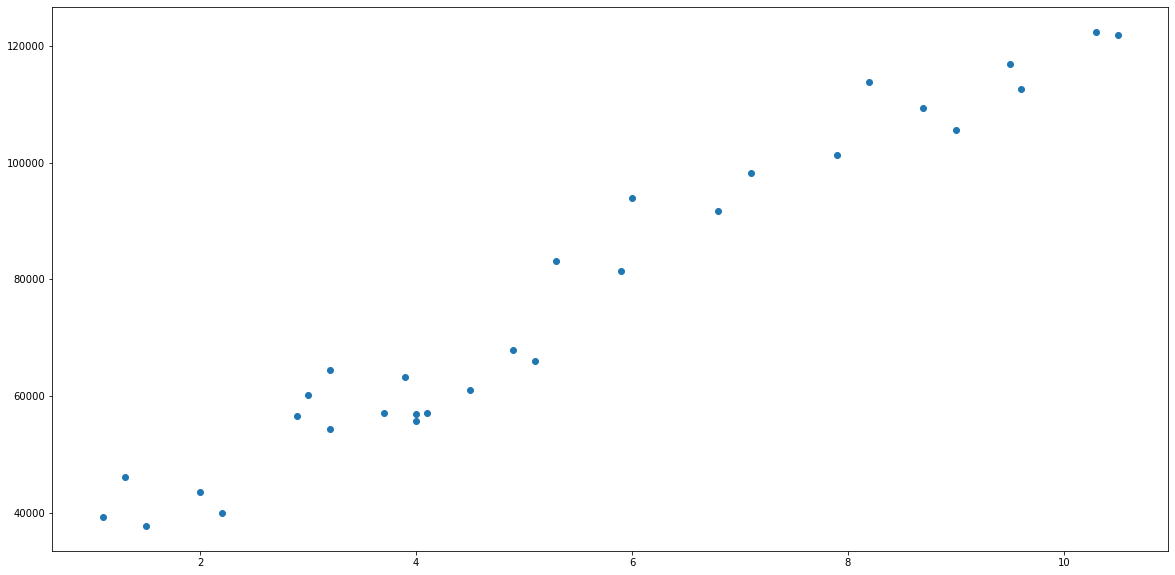

In [3426]:
data = pd.read_csv('Salary_Data.csv')
years = data['YearsExperience']
salary = data['Salary']
plt.plot(years, salary, 'o')

In [3427]:
def draw_row(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(0, 10, 100)
    ax1.plot(years, salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-5000, 30000, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f_unnormalized(X, range(0, 30)),
                levels=sorted([f_unnormalized(p, range(0, 30)) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')


def draw_normalized(points):
    res = points[-1]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    x = np.linspace(-2, 2, 100)
    ax1.plot(normalized_exp, normalized_salary, 'o')
    ax1.plot(x, res[0] * x + res[1])

    t = np.linspace(-1, 2.5, 100)
    X = np.meshgrid(t, t)
    ax2.contour(X[0], X[1], f_normalized(X, range(0, 30)),
                levels=sorted([f_normalized(p, range(0, 30)) for p in points] + list(np.linspace(-1, 1, 100))))
    ax2.plot(points[:, 0], points[:, 1], 'o-', color='red')

In [3428]:
function_call_cnt = 0
grad_call_cnt = 0
term_call_cnt = 0

Минимизируемая функция: $\sum_{i=0}^{29} (x_0 \times years_i + x_1 - salary_i)^2$

In [3429]:
def f_unnormalized(x, idxs):
    res = 0
    for i in idxs:
        res += (x[0] * years[i] + x[1] - salary[i]) ** 2
    return res

In [3430]:
def const_lr(n, start):
    return start


def exp_lr(n, start):
    k = 0.01
    return start * np.exp(-k * n)


In [3431]:
def partial(f, i, x, idxs):
    h = 1e-3
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x, idxs):
    global grad_call_cnt
    grad_call_cnt += 1

    return [partial(f, i, x, idxs) for i in range(len(x))]


def minibatch_grad(func, x, batch):
    idxs = random.sample(range(0, 30), batch)
    return grad(func, x, idxs)

In [3432]:
def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = np.zeros((epoch, 2))
    points[0] = x
    for i in range(1, epoch):
        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points[i] = x

    return points

In [3433]:
def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=30)

In [3434]:
def sgd(f, lr, start, lr_strategy=exp_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=1)

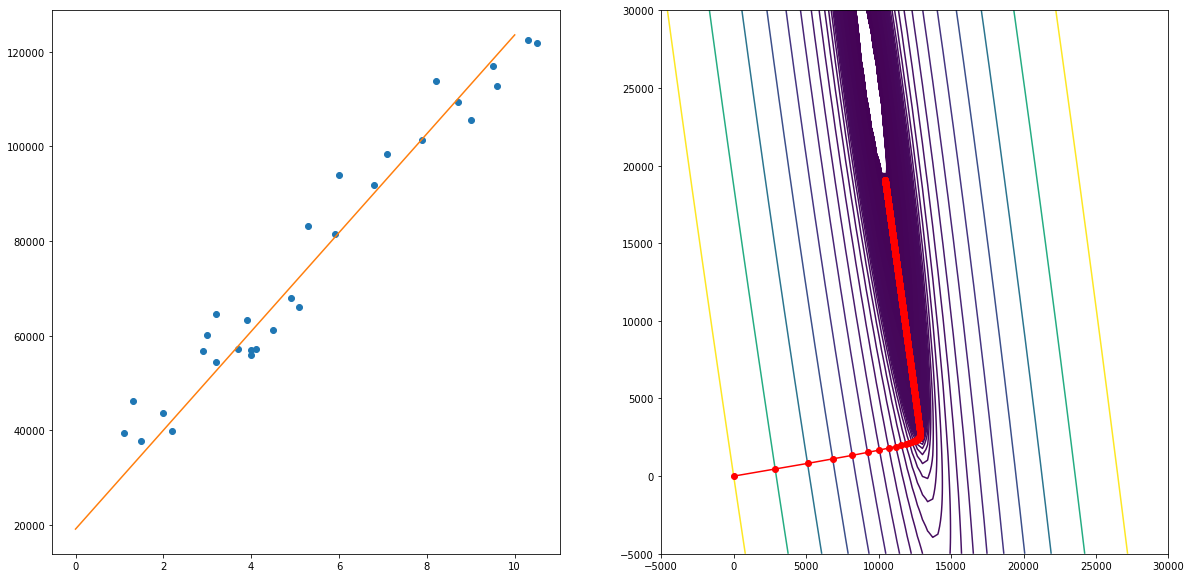

In [3435]:
draw_row(gd(f_unnormalized, 0.0001, start=[1, 1], epoch=1000))

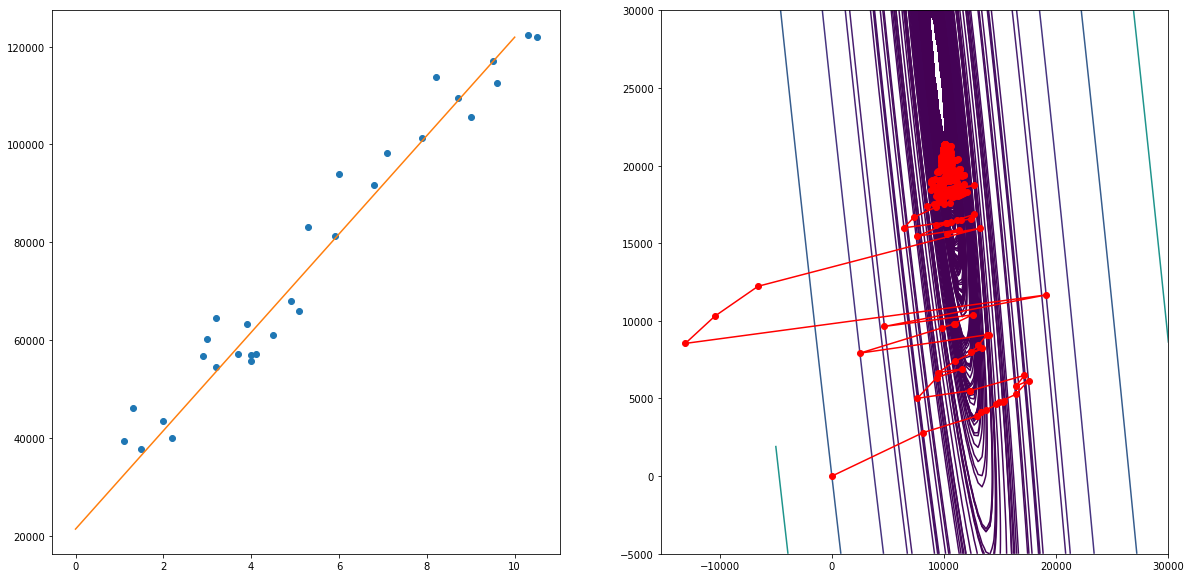

In [3436]:
draw_row(sgd(f_unnormalized, 0.025, start=[1, 1], epoch=1000))

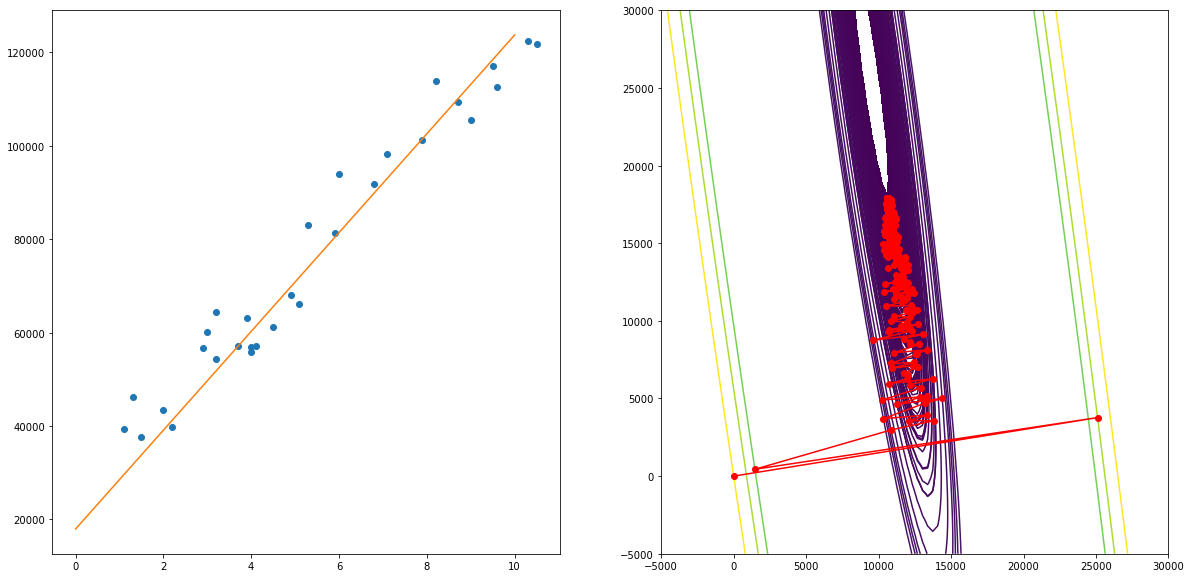

In [3437]:
draw_row(minibatch_sgd(f_unnormalized, 0.005, start=[1, 1], epoch=1000, batch=5))

# Задание 2

In [3438]:
avg_exp = years.mean()
dev_exp = years.std()

avg_salary = salary.mean()
dev_salary = salary.std()

In [3439]:
normalized_exp = [(e - avg_exp) / dev_exp for e in years]
normalized_salary = [(e - avg_salary) / dev_salary for e in salary]

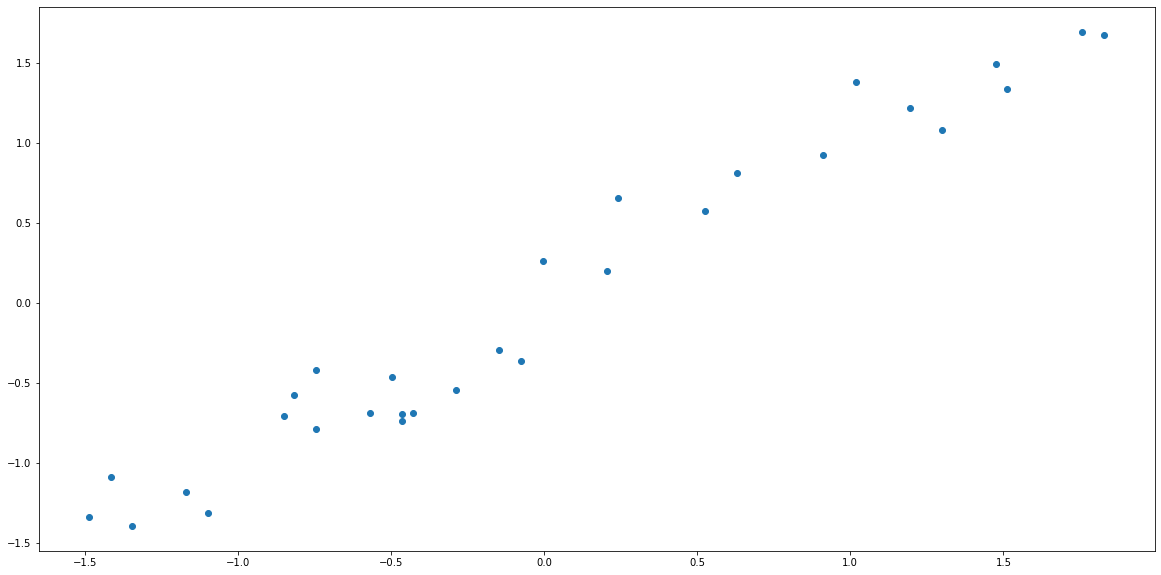

In [3440]:
plt.plot(normalized_exp, normalized_salary, 'o')

In [3441]:
def f_normalized(x, idxs):
    global function_call_cnt
    global term_call_cnt

    function_call_cnt += 1

    res = 0
    for i in idxs:

        term_call_cnt += 1
        res += (x[0] * normalized_exp[i] + x[1] - normalized_salary[i]) ** 2
    return res

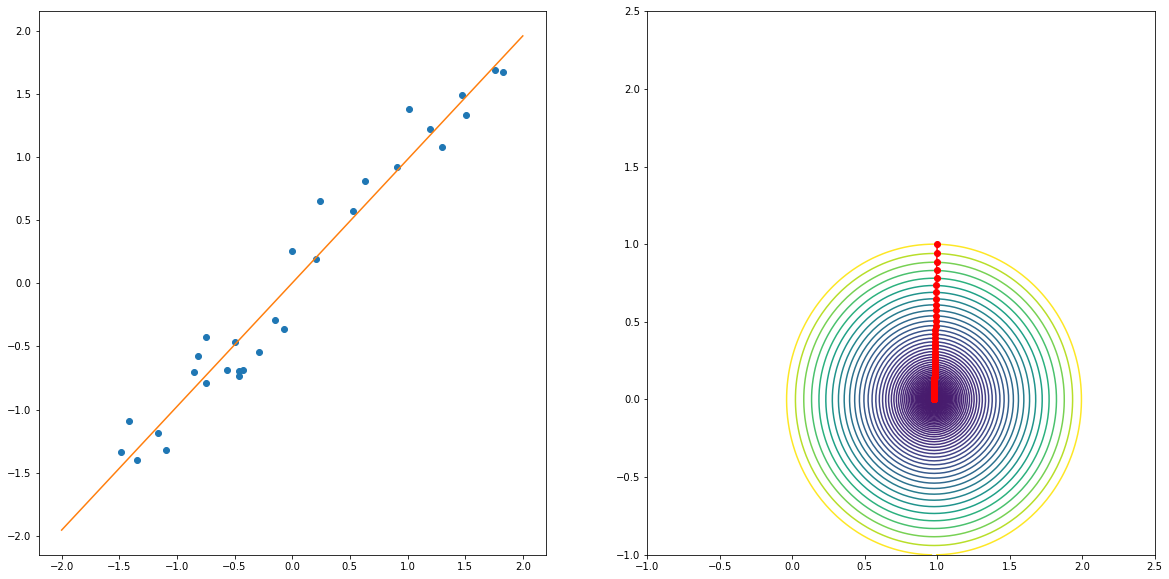

In [3442]:
draw_normalized(gd(f_normalized, 0.001, start=[1, 1], epoch=100))

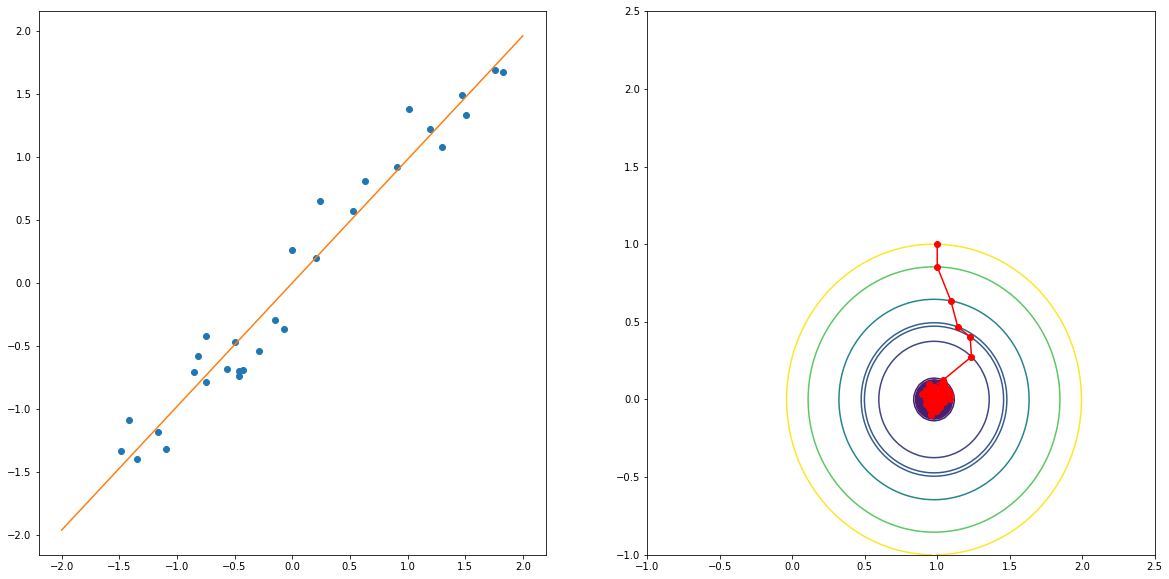

In [3443]:
draw_normalized(sgd(f_normalized, 0.1, start=[1, 1], epoch=1000))

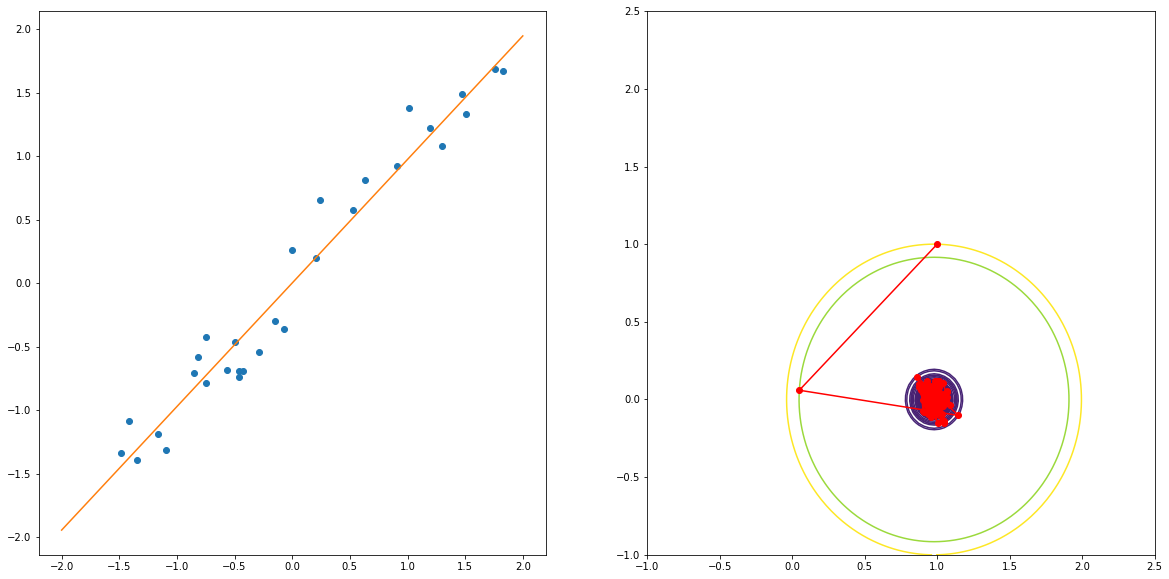

In [3444]:
draw_normalized(minibatch_sgd(f_normalized, 0.1, start=[1, 1], epoch=1000, batch=5))

## Задание 3

In [3445]:
def cancel_condition(x):
    return f_normalized(x, range(0, 30)) < 1.3

### Momentum

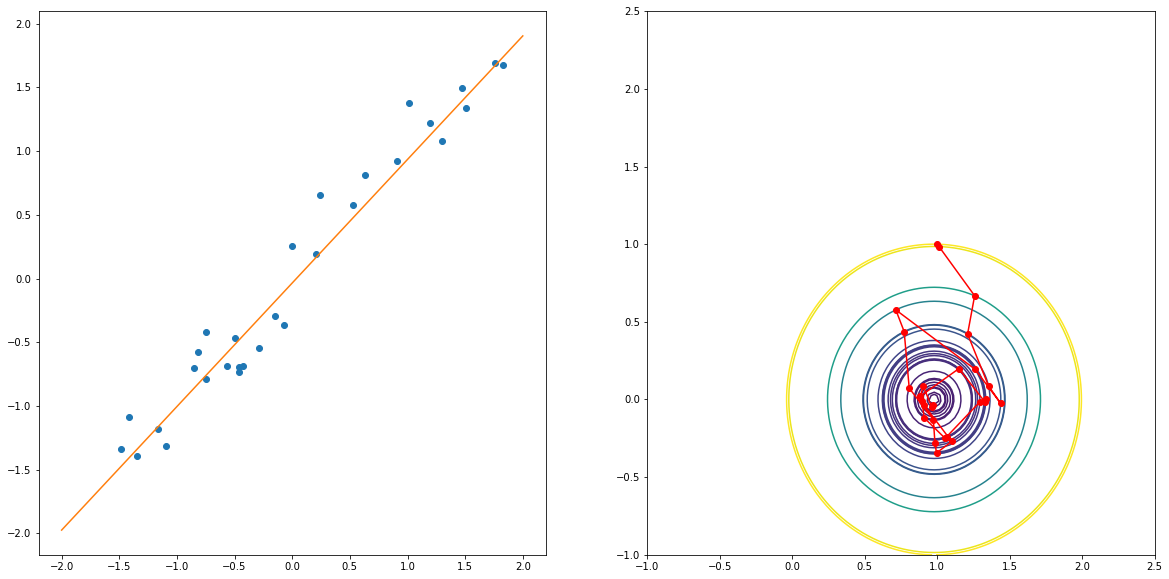

In [3446]:
def sgd_with_momentum(f, b, lr, start, lr_strategy=const_lr, epoch=20, batch=1):
    x = start
    points = list()
    points.append(start)
    prev_gr = np.array([0, 0])
    points[0] = x
    for i in range(1, epoch):
        new_grad = np.array(minibatch_grad(f, x, batch))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad
        x = x - new_step
        prev_gr = new_grad
        points.append(x)
        if cancel_condition(x):
            break

    return np.array(points)


draw_normalized(sgd_with_momentum(f_normalized, b=0.2, lr=0.01, lr_strategy=const_lr, start=[1, 1], epoch=1000, batch=1))

## Nesterov momentum

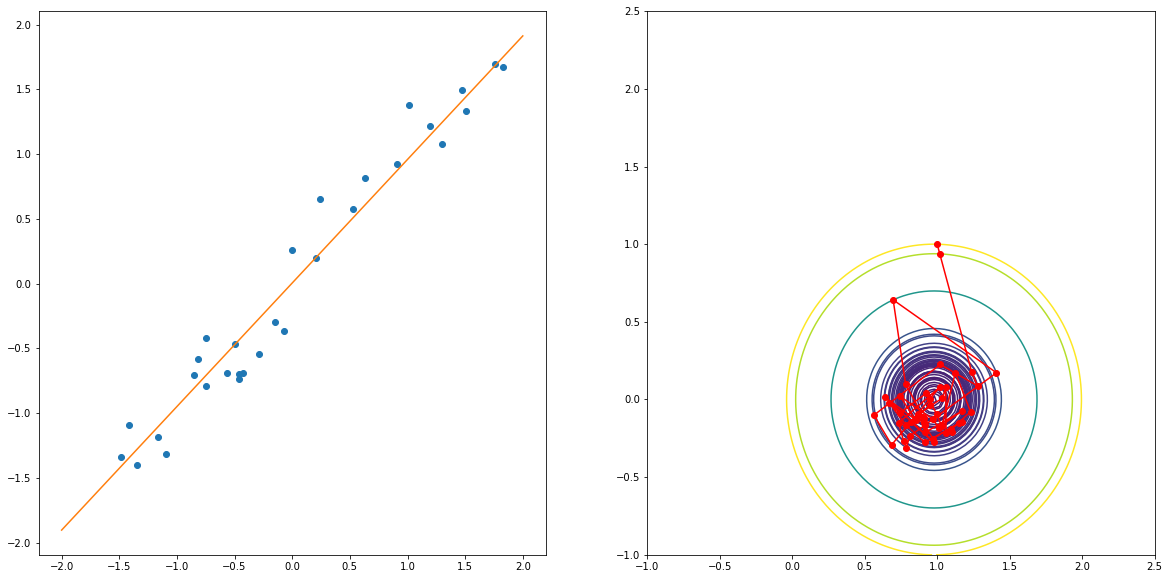

In [3447]:
def sgd_with_nesterov_momentum(f, b, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    points = list()
    points.append(start)
    prev_gr = np.array([0, 0])
    for i in range(1, epoch):
        new_grad = np.array(minibatch_grad(f, x - b * prev_gr, batch))
        new_step = b * prev_gr + lr_strategy(i, lr) * new_grad
        x = x - new_step
        prev_gr = new_grad
        points.append(x)
        if cancel_condition(x):
            break

    return np.array(points)


draw_normalized(sgd_with_nesterov_momentum(f_normalized, b=0.3, lr=0.025, start=[1, 1], epoch=1000))

## AdaGrad

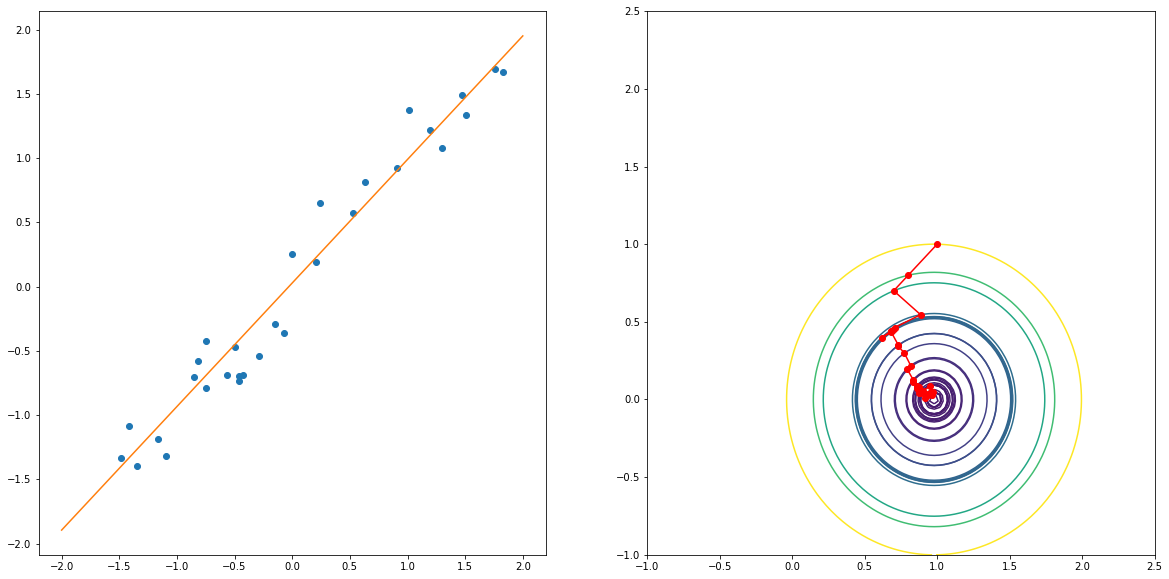

In [3448]:
def adagrad(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    s = np.array([0, 0])
    points = list()
    points.append(start)
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        s = s + np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points.append(x)
        if cancel_condition(x):
            break

    return np.array(points)


draw_normalized(adagrad(f_normalized, lr=0.2, lr_strategy=const_lr, start=[1, 1], epoch=1000))

## RMSProp

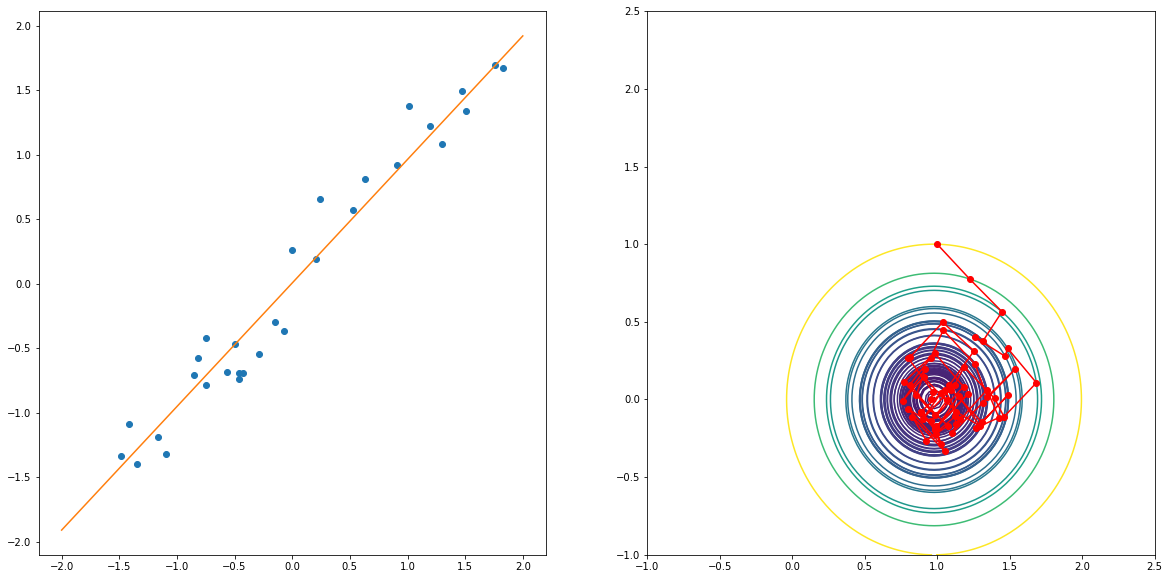

In [3449]:
def rmsprop(f, b, lr, start, lr_strategy=const_lr, epoch=20, batch=1):
    x = start
    s = np.array([0, 0])
    points = list()
    points.append(start)
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        s = b * s + (1 - b) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) / np.sqrt(s) * gr
        points.append(x)
        if cancel_condition(x):
            break

    return np.array(points)


draw_normalized(rmsprop(f_normalized, lr=0.2, b=0.2, lr_strategy=const_lr, start=[1, 1], epoch=1000))

## Adam

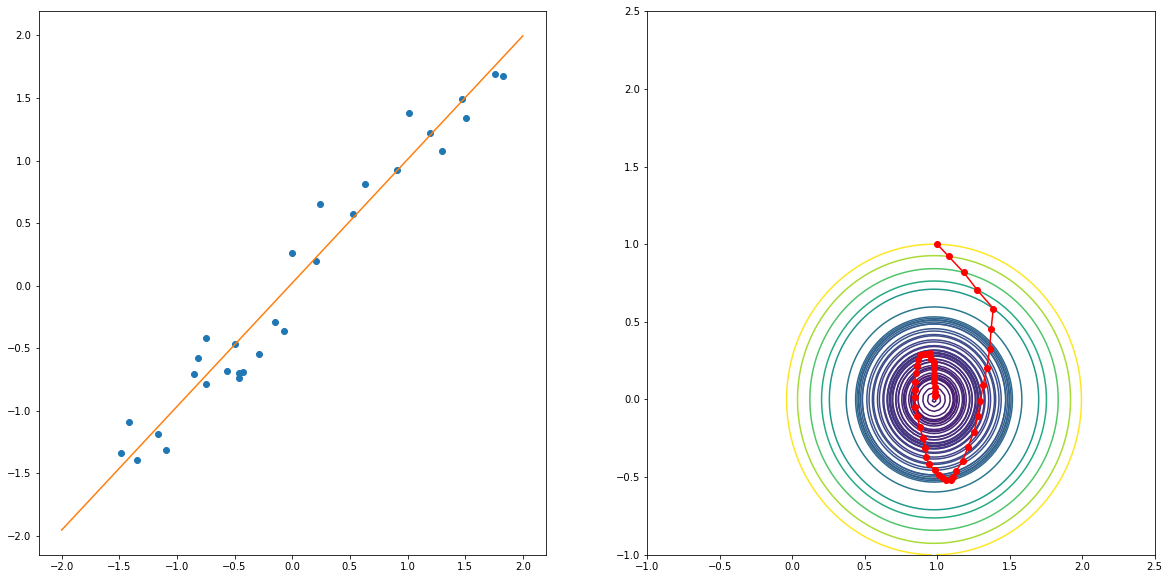

In [3450]:
def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    prev_grad = np.array([0, 0])
    prev_v = np.array([0, 0])
    points = list()
    points.append(start)
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)
        if cancel_condition(x):
            break

    return np.array(points)


draw_normalized(adam(f_normalized, lr=0.025, b1=0.9, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=1000))

In [3451]:
def profile(name, batches, f, *args, **kwargs):
    global function_call_cnt
    global grad_call_cnt
    global term_call_cnt

    res_list = list()
    func_calls = list()
    term_calls = list()
    grad_calls = list()

    start = time.time()

    for i in range(1000):
        function_call_cnt = 0
        grad_call_cnt = 0
        term_call_cnt = 0
        r = np.array(f(*args, **kwargs))
        func_calls.append(function_call_cnt)
        grad_calls.append(grad_call_cnt)
        term_calls.append(term_call_cnt)
        res_list.append(len(r))

    end = time.time()

    exec_time = (end-start)*1000.0
    number_of_iterations = np.median(res_list)
    func_call = np.median(func_calls)
    term_call = np.median(term_calls)
    grad_call = np.median(grad_calls)


    return {"Method": name, "Number of batches": batches, "Time of 1000 execution": exec_time, "Number of iteration":number_of_iterations, "Number of function calls" : func_call, "Number of term calls":term_call, "Number of grad calls" : grad_call }

### SGD with momentum 1 batch

In [3452]:
sgd_with_momentum_1_batch = profile("SGD with momentum", 1, sgd_with_momentum, f_normalized, b=0.2, lr=0.10, start=[1, 1], epoch=10000, batch=1)

### SGD with Nesterov momentum 1 batch

In [3453]:
sgd_with_nesterov_momentum_1_batch = profile("SGD with Nesterov momentum", 1, sgd_with_nesterov_momentum, f_normalized, b=0.2, lr=0.025, start=[1, 1], epoch=1000, batch=1)

### Adagrad 1 batch

In [3454]:
adagrad_1_batch = profile("Adagrad", 1, adagrad, f_normalized, lr=0.3, lr_strategy=const_lr, start=[1, 1], epoch=10000, batch=1)

### Adagrad 10 batch

In [3455]:
adagrad_10_batch = profile("Adagrad", 10, adagrad, f_normalized, lr=0.3, lr_strategy=const_lr, start=[1, 1], epoch=10000, batch=10)

### Adagrad 30 batch

In [3456]:
adagrad_30_batch = profile("Adagrad", 30, adagrad, f_normalized, lr=0.3, lr_strategy=const_lr, start=[1, 1], epoch=10000, batch=30)

### RMSProp 1 batch

In [3468]:
rmsprop_1_batch = profile("RMSProp", 1, rmsprop, f_normalized, lr=0.2, b=0.8, lr_strategy=const_lr, start=[1, 1], epoch=1000, batch=1)


### RMSProp 10 batch

In [3470]:
rmsprop_10_batch = profile("RMSProp", 10, rmsprop, f_normalized, lr=0.2, b=0.8, lr_strategy=const_lr, start=[1, 1], epoch=1000, batch=10)

### RMSProp 30 batch

In [3471]:
rmsprop_30_batch = profile("RMSProp", 30, rmsprop, f_normalized, lr=0.2, b=0.8, lr_strategy=const_lr, start=[1, 1], epoch=1000, batch=30)


### Adam 1 batch

In [3472]:
adam_1_batch = profile("Adam", 1, adam, f_normalized, lr=0.024, b1=0.8, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=10000, batch=1)

### Adam 10 batch

In [3473]:
adam_10_batch = profile("Adam", 10, adam, f_normalized, lr=0.024, b1=0.8, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=10000, batch=10)

### Adam 30 batch

In [3474]:
adam_30_batch = profile("Adam", 30, adam, f_normalized, lr=0.024, b1=0.8, b2=0.999, lr_strategy=const_lr, start=[1, 1], epoch=10000, batch=30)

In [3478]:
%%capture

df = DataFrame(columns=["Method", "Number of batches", "Number of iteration", "Time of 1000 execution", "Number of function calls", "Number of term calls", "Number of grad calls"])

df = df.append(sgd_with_momentum_1_batch, ignore_index=True)

df = df.append(sgd_with_nesterov_momentum_1_batch, ignore_index=True)

df = df.append(adagrad_1_batch, ignore_index=True)
df = df.append(adagrad_10_batch, ignore_index=True)
df = df.append(adagrad_30_batch, ignore_index=True)

df = df.append(rmsprop_1_batch, ignore_index=True)
df = df.append(rmsprop_10_batch, ignore_index=True)
df = df.append(rmsprop_30_batch, ignore_index=True)

df = df.append(adam_1_batch, ignore_index=True)
df = df.append(adam_10_batch, ignore_index=True)
df = df.append(adam_30_batch, ignore_index=True)


In [3483]:
df

,Method,Number of batches,Number of iteration,Time of 1000 execution,Number of function calls,Number of term calls,Number of grad calls
0,SGD with momentum,1,54.0,5945.702076,265.0,1802.0,53.0
1,SGD with Nesterov momentum,1,24.5,2612.383366,117.5,799.0,23.5
2,Adagrad,1,19.5,1420.488358,92.5,629.0,18.5
3,Adagrad,10,15.0,1666.024208,70.0,980.0,14.0
4,Adagrad,30,14.0,2974.107027,65.0,1950.0,13.0
5,RMSProp,1,31.0,2915.968418,150.0,1020.0,30.0
6,RMSProp,10,8.0,1181.139708,35.0,490.0,7.0
7,RMSProp,30,6.0,1520.102978,25.0,750.0,5.0
8,Adam,1,30.0,3072.949886,145.0,986.0,29.0
9,Adam,10,18.0,2632.226944,85.0,1190.0,17.0
